Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


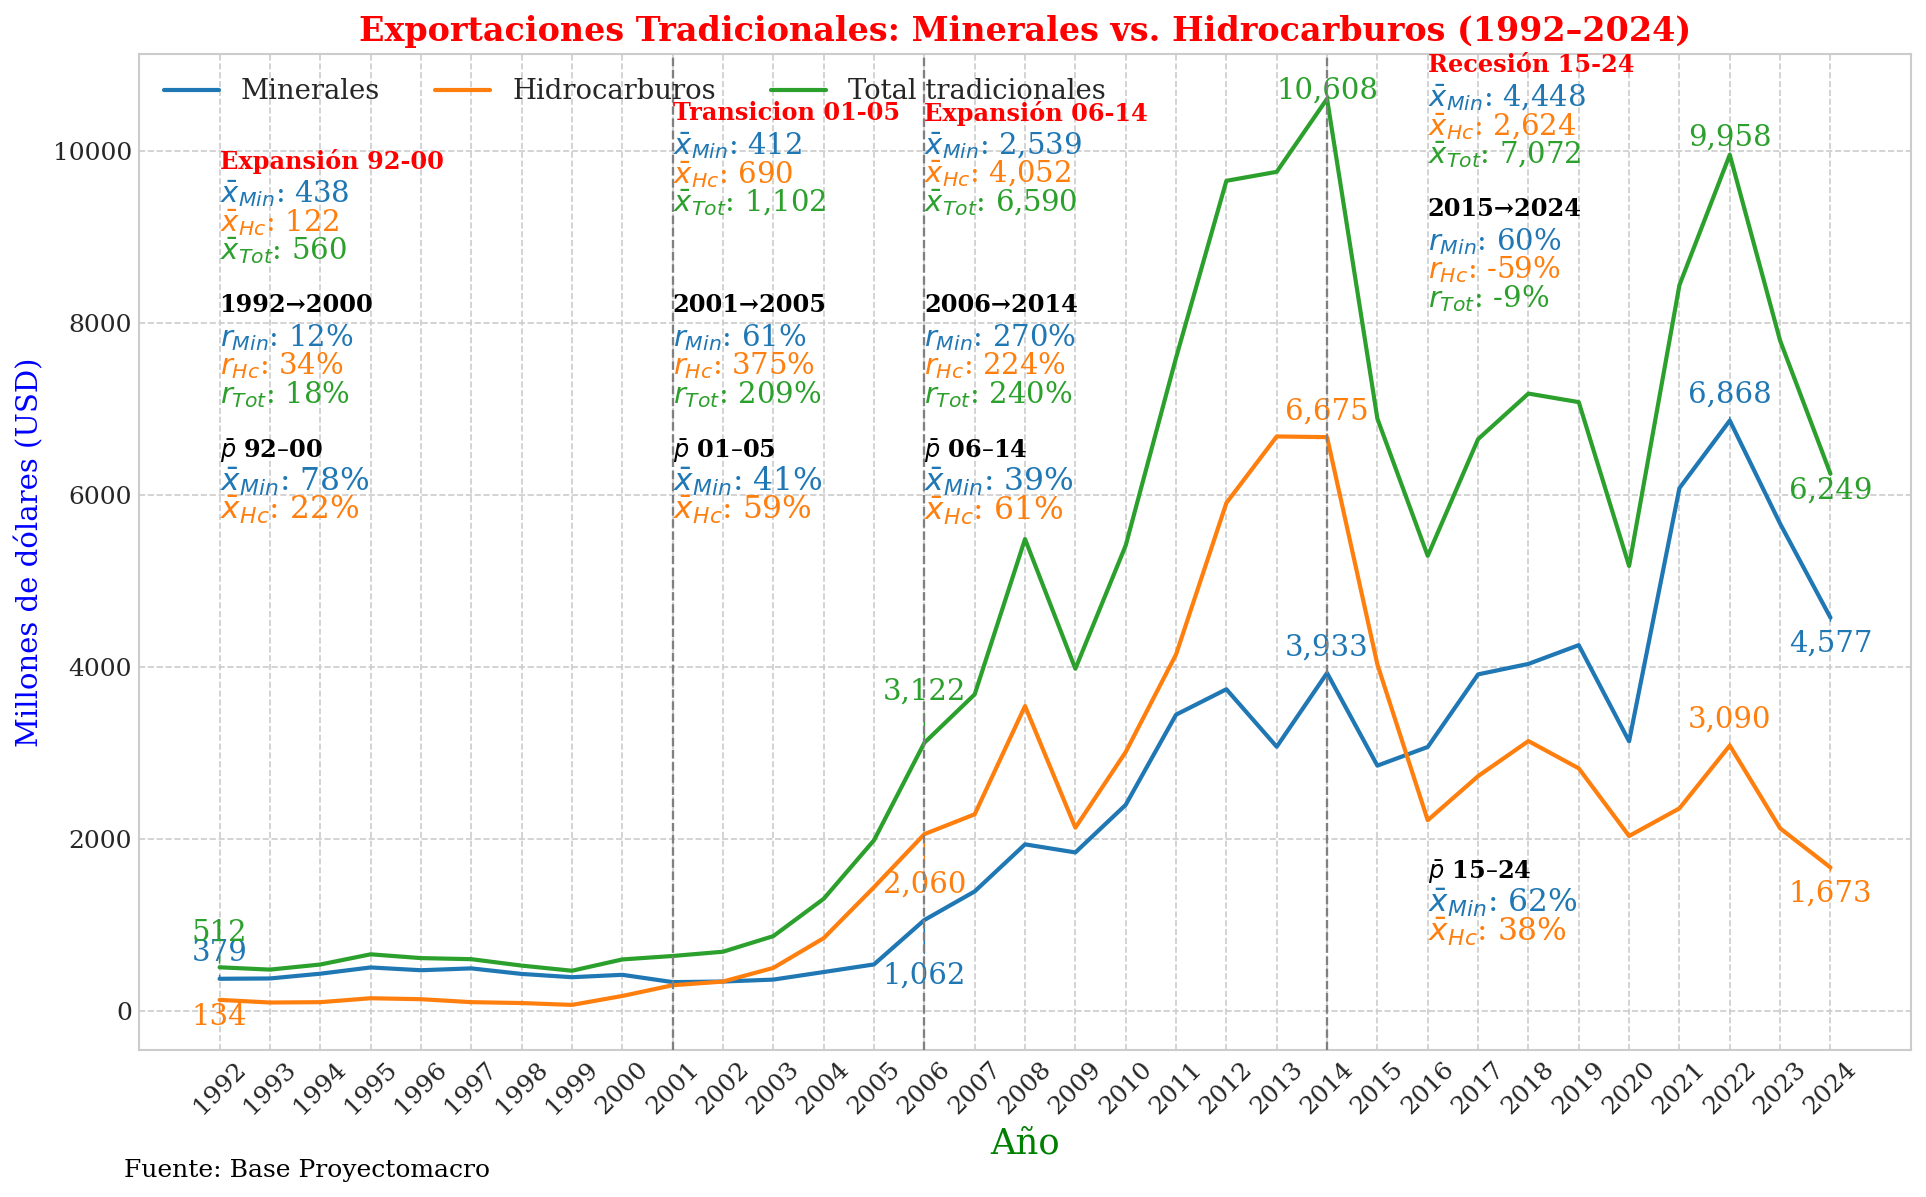

In [2]:
# ───────────────────────── 0. IMPORTS Y CONFIGURACIÓN GENERAL ─────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# utilidades propias
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from config import *          # CYCLES, hitos_v, annot_years, periodos_tasas …

# Configuración general
output_dir = f"../../../../assets/tesis/serie_completa/exportaciones"
os.makedirs(output_dir, exist_ok=True)

set_style()                   # reemplaza todos los rcParams manuales

# ───────────────────────────── 1. CARGA DE DATOS ─────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (pd.read_sql("SELECT * FROM exportaciones_tradicionales", conn)
            .set_index("año")
            .sort_index())

df["total"] = df["minerales"] + df["hidrocarburos"]

# ──────────────── 2. COMPONENTES, COLORES Y ABREVIATURAS ────────────────
componentes = [
    ("minerales",    "Minerales"),
    ("hidrocarburos","Hidrocarburos"),
    ("total",        "Total tradicionales"),
]
cols_componentes = [c for c, _ in componentes]

custom_colors = {'minerales': '#1f77b4', 'hidrocarburos': '#ff7f0e', 'total': '#2ca02c'}
abbr = {"minerales":"Min", "hidrocarburos":"Hc", "total":"Tot"}

# ──────────────── 3. PREPARACIÓN ────────────────
CYCLES   = adjust_cycles(df, CYCLES)                  # usa definición global
annotate_years = [1992, 2000, 2006, 2014, 2024]             # específicos
annotate_years.append(2022)
periodos_componentes = adjust_periods(df, periodos_tasas)   # para growth-boxes
cycles_stat  = {name: df.loc[slc, cols_componentes].mean().to_dict()
                      for name, slc in CYCLES.items()}

# ──────────────── 4. OFFSETS ────────────────
hitos_offsets = {año: 0.80 for año in hitos_v}

annotation_offsets = {
    "minerales": {
        1992: (0, 300),
        2001: (0, 350),
        2006: (0, -650),
        2014: (0, 300),
        2022: (0, 300),
        2024: (0, -300),
    },
    "hidrocarburos": {
        1992: (0, -200),
        2001: (0, -290),
        2006: (0, -590),
        2014: (0, 300),
        2022: (0, 300),
        2024: (0, -300),
    },
    "total": {
        1992: (0, 400),
        2001: (0, 500),
        2006: (0, 600),
        2014: (0, 100),
        2022: (0, 200),
        2024: (0, -200),
    },
}

medias_offsets = {
    "Expansión 92-00":  (1992, 0.90),
    "Transicion 01-05": (2001, 0.95),
    "Expansión 06-14":  (2006, 0.95),
    "Recesión 15-24":   (2016, 1.00),
}

tasas_offsets = {
    "1992-2000": (1992, 0.75),
    "2001-2005": (2001, 0.75),
    "2006-2014": (2006, 0.75),
    "2015-2024": (2016, 0.85),
}

participation_offsets = {
    "1992-2000": (1992, 0.60),
    "2001-2005": (2001, 0.60),
    "2006-2014": (2006, 0.60),
    "2015-2024": (2016, 0.16),
}







# ───────────────────────────── 5. GRÁFICA ─────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"Exportaciones Tradicionales: Minerales vs. Hidrocarburos ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de dólares (USD)",
    source_text="Fuente: Base Proyectomacro",
    legend_ncol=3
)

add_hitos(ax, df.index, hitos_v, hitos_offsets)

line_spacing = ax.get_ylim()[1] * 0.03
add_cycle_means_multi(ax, cycles_stat, medias_offsets, abbr, custom_colors, line_spacing)

add_year_value_annotations(ax, df, annotate_years, cols_componentes,
                           annotation_offsets, custom_colors, arrow_lw=0.7)

add_period_growth_annotations_multi(
    ax, df, periodos_componentes, cols_componentes, tasas_offsets, custom_colors, abbr
)

add_participation_cycle_boxes(
    ax, df, periodos_componentes, ["minerales","hidrocarburos"], "total",
    participation_offsets, abbr_map=abbr,
    colors={c: custom_colors[c] for c in ["minerales","hidrocarburos"]}
)

plt.savefig(os.path.join(output_dir, "exportaciones_tradicionales.png"), dpi=300)
plt.show()

In [2]:
periodos

NameError: name 'periodos' is not defined